<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/GRU_ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [12]:
# Load data
df = pd.read_csv('/content/ReviewTokoBaju.csv')

# Hapus baris dengan review kosong
df = df[['Review Text', 'Recommended IND']].dropna()

# Ubah nama kolom
df.columns = ['text', 'label']

# Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=100, padding='post')

# Konversi ke tensor
X = torch.tensor(padded, dtype=torch.long)
y = torch.tensor(df['label'].values, dtype=torch.float32)


In [13]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ReviewDataset(X, y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)


In [14]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        out = self.fc(h_n.squeeze(0))
        return self.sigmoid(out)

vocab_size = 5000
model = GRUModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64)


In [23]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validasi
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Tampilkan hasil per epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch [1/10] - Train Loss: 0.0234 - Train Acc: 11.6820 | Val Loss: 0.4659 - Val Acc: 11.2011
Epoch [2/10] - Train Loss: 0.0194 - Train Acc: 11.6820 | Val Loss: 0.4688 - Val Acc: 11.2011
Epoch [3/10] - Train Loss: 0.0193 - Train Acc: 11.6820 | Val Loss: 0.4781 - Val Acc: 11.2011
Epoch [4/10] - Train Loss: 0.0185 - Train Acc: 11.6820 | Val Loss: 0.5021 - Val Acc: 11.2011
Epoch [5/10] - Train Loss: 0.0140 - Train Acc: 11.6820 | Val Loss: 0.5544 - Val Acc: 11.2011
Epoch [6/10] - Train Loss: 0.0073 - Train Acc: 11.6820 | Val Loss: 0.5880 - Val Acc: 11.2011
Epoch [7/10] - Train Loss: 0.0134 - Train Acc: 11.6820 | Val Loss: 0.5083 - Val Acc: 11.2011
Epoch [8/10] - Train Loss: 0.0104 - Train Acc: 11.6820 | Val Loss: 0.6165 - Val Acc: 11.2011
Epoch [9/10] - Train Loss: 0.0053 - Train Acc: 11.6820 | Val Loss: 0.6115 - Val Acc: 11.2011
Epoch [10/10] - Train Loss: 0.0087 - Train Acc: 11.6820 | Val Loss: 0.6488 - Val Acc: 11.2011


In [24]:
# Kumpulkan hasil prediksi
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze().cpu().numpy()
        probs = outputs
        preds = (outputs >= 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Hitung metrik
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Akurasi: 0.8883
Presisi: 0.9158
Recall: 0.9521
F1 Score: 0.9336
AUC: 0.9151


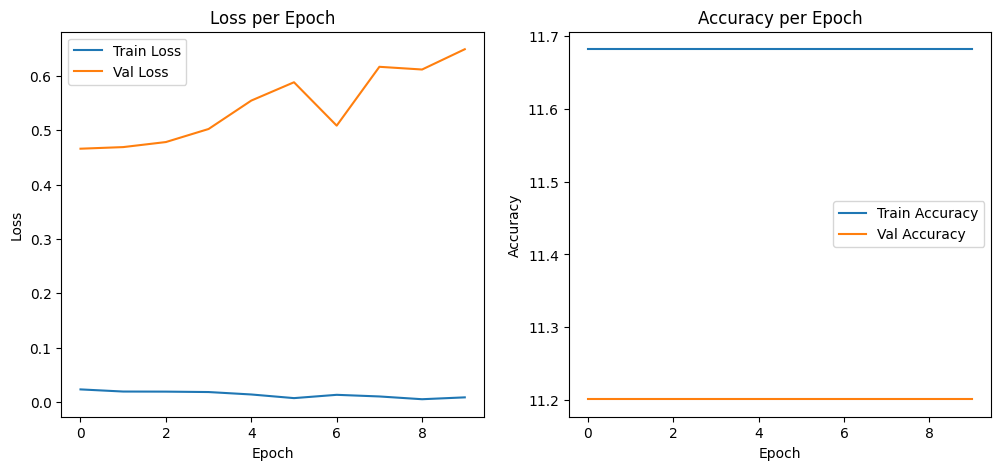

In [25]:
# Visualisasi akurasi & loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


#Tensorflow

In [34]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [35]:
# Load dataset
data = pd.read_csv('ReviewTokoBaju.csv')

# Pilih kolom yang relevan untuk model (Review Text sebagai input dan Recommended IND sebagai label)
X = data['Review Text'].fillna('')  # Mengisi nilai NaN dengan string kosong
y = data['Recommended IND']  # Target label (0 atau 1)

# Tokenisasi dan padding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=300)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [36]:
model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=128, input_length=300))  # Layer Embedding
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))  # Layer GRU dengan dropout
model.add(Dense(64, activation='relu'))  # Fully connected layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


294/294 ━━━━━━━━━━━━━━━━━━━━ 272s 893ms/step - accuracy: 0.8357 - loss: 0.4338 - val_accuracy: 0.8817 - val_loss: 0.2825
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 272s 927ms/step - accuracy: 0.8989 - loss: 0.2478 - val_accuracy: 0.8923 - val_loss: 0.2670
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 272s 924ms/step - accuracy: 0.9242 - loss: 0.1866 - val_accuracy: 0.8983 - val_loss: 0.2691
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 326s 939ms/step - accuracy: 0.9395 - loss: 0.1519 - val_accuracy: 0.8876 - val_loss: 0.2923
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 315s 915ms/step - accuracy: 0.9546 - loss: 0.1198 - val_accuracy: 0.8921 - val_loss: 0.2985
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 323s 920ms/step - accuracy: 0.9656 - loss: 0.0971 - val_accuracy: 0.8868 - val_loss: 0.3525
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 312s 887ms/step - accuracy: 0.9733 - loss: 0.0725 - val_accuracy: 0.8821 - val_loss: 0.3815
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 272s 924ms/step - accuracy: 0.9792 - loss: 0.06

In [37]:
y_pred_prob = model.predict(X_test)  # Probabilitas prediksi (output sigmoid)
y_pred = (y_pred_prob > 0.5).astype('int32')  # Prediksi biner (0 atau 1)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Menampilkan hasil metrik
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step
Accuracy: 0.8859
Precision: 0.9053
Recall: 0.9613
F1 Score: 0.9324
ROC AUC: 0.8991


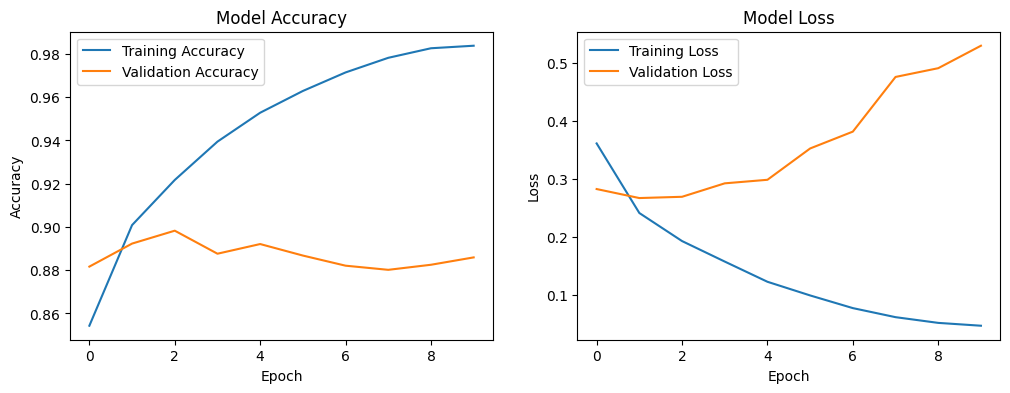

In [38]:
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()